In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [ ]:
! ls

In [ ]:
%cd gdrive/My Drive/

In [1]:
import torch
import random
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt 
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torch.utils.data
import torchvision
import numpy as np
from torch.autograd import Variable

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(74, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 64)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 64),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 8, 8)

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
#HyperParameters
Batch_size=100
lr=0.0002
epochs=10

In [6]:

'''
Data_preprocessing:
1 : Resizing the Image 
2 : Convert the Image to Torch Tensor
3 : Normalize the Pixel value with additional Noise
'''
Data_transform=transforms.Compose([ transforms.Resize(8),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.1307,),std=(0.3081,))])

In [7]:
trainset=torchvision.datasets.MNIST(root='../data',train=True,download=True,transform=Data_transform)
trainloader=DataLoader(trainset,batch_size=Batch_size,num_workers=2,shuffle=True)

In [8]:
#Utlitiy Function to Show the Generated Output
def showimage(images):
    image=images.cpu().numpy()
    image=image/2+0.5
    plt.imshow(np.transpose(images, axes=(1, 2, 0)))
    plt.axis('off')
    plt.show()

torch.Size([100, 1, 8, 8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


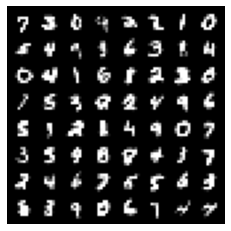

In [9]:
#Sample input Images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
showimage(make_grid(images[0:64]))

In [10]:
#Initializing Generator and Discriminator
generator=Generator().to(device)
discriminator=Discriminator().to(device)

gen_params=list(generator.parameters())
print(len(gen_params))

disc_params=list(discriminator.parameters())
print(len(disc_params))
z = torch.randn(10, 100, device=device)
print(z.shape)
gen_labels = torch.randint(0, 10, (10,), device=device, dtype=torch.long)
    #Generate Image with Noise and Labels
l=generator(z,gen_labels)
l

9
9
torch.Size([10, 100])


tensor([[[ 1.1826e-02,  3.2993e-02,  3.7337e-02, -1.8821e-03, -6.1387e-03,
           1.0400e-01,  2.6050e-03,  4.2848e-02],
         [-3.0802e-02,  3.9360e-02,  7.1297e-02, -8.0361e-03, -1.0903e-01,
          -3.2840e-02, -2.0068e-02,  1.9859e-02],
         [ 8.3594e-02,  1.9363e-02,  1.8507e-02, -2.1207e-02,  4.8928e-03,
          -5.0561e-02,  5.2163e-02, -1.0688e-01],
         [ 3.8461e-02, -3.2735e-02, -1.6626e-02, -1.4647e-02,  2.2450e-02,
           1.6357e-03, -1.7709e-02, -2.0903e-02],
         [ 8.4273e-03,  4.7043e-02, -3.4088e-03, -8.7753e-03, -6.1502e-02,
          -2.4482e-02, -2.5541e-02, -8.9770e-03],
         [-2.9225e-02,  1.3276e-02,  4.6406e-02, -8.9087e-03,  1.8622e-02,
          -1.9153e-02, -9.9726e-02,  3.2385e-03],
         [-1.1733e-01,  5.4384e-02, -3.5372e-02, -5.3400e-02,  5.2268e-02,
          -1.1544e-02,  7.2292e-02,  2.5970e-02],
         [-3.4056e-02, -2.6836e-02, -1.0148e-01,  2.5104e-02,  2.4156e-02,
           1.4361e-02,  4.5725e-02,  1.5389e-02]],

In [11]:
#LOSS
criterion = nn.BCELoss().cuda()

# Optimizer
optimG = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
optimD = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))


In [12]:
#Label Smoothening
real_labels = 0.7 + 0.5 * torch.rand(10, device=device)  
fake_labels = 0.3 * torch.rand(10, device=device)

In [13]:
''' Function :train_generator
 -----To train the Generator Network-----
'''
def train_generator(batch_size,generator,discriminator):
    optimG.zero_grad()
    #generate Noise Samples and Randorm Labels from Latent Space
    z = torch.randn(batch_size, 100, device=device)
    gen_labels = torch.randint(0, 10, (batch_size,), device=device, dtype=torch.long)
    #Generate Image with Noise and Labels
    gen_imgs = generator(z, gen_labels)

    #Image Generated is passed into Discriminator so as to Fool Discriminator and Loss is computed
    validity = discriminator(gen_imgs, gen_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size,device=device)))
    #Backprop and Weight Update
    g_loss.backward()
    optimG.step()
    return g_loss.item()

In [14]:
''' Function :train_discriminator
 ------To train the Discriminator Network------
'''
def train_discriminator(batch_size,generator,discriminator,real_img,label,real,fake):
    optimD.zero_grad()
    validity_label = torch.full((batch_size,), real, device=device)
    #Discriminator classifies the Real Images and Their Class Label
    real_pred= discriminator(real_img,label)
    d_real_loss = criterion(real_pred,validity_label)
    D_x = real_pred.mean().item()
    
    #Noise and random Sample is generated for Fake Images
    z = Variable(torch.randn(batch_size, 100,device=device))
    fake_lbels = torch.randint(0, 10, (batch_size,), device=device, dtype=torch.long)
    fake_images = generator(z, fake_lbels)
    fake_validity = discriminator(fake_images, fake_lbels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size,device=device)))
    d_loss = d_real_loss + fake_loss
    d_loss.backward()
    optimD.step()
    return d_loss.item(),D_x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 0/10] [Batch 599/600] [D loss: 1.038925] [G loss: 1.424628]


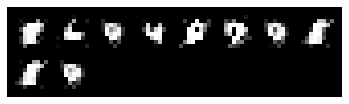

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 1/10] [Batch 599/600] [D loss: 1.064182] [G loss: 1.829672]


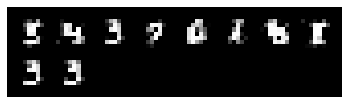

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 2/10] [Batch 599/600] [D loss: 0.851934] [G loss: 2.621915]


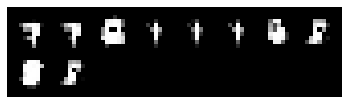

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 3/10] [Batch 599/600] [D loss: 0.779531] [G loss: 3.062301]


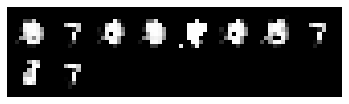

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 4/10] [Batch 599/600] [D loss: 0.810373] [G loss: 3.040044]


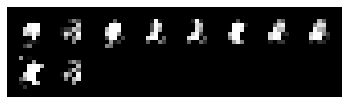

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 5/10] [Batch 599/600] [D loss: 0.728441] [G loss: 3.556905]


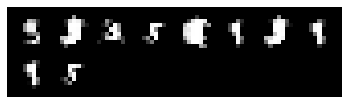

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 6/10] [Batch 599/600] [D loss: 0.755043] [G loss: 2.820496]


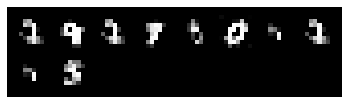

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 7/10] [Batch 599/600] [D loss: 0.754870] [G loss: 3.049341]


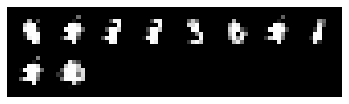

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 8/10] [Batch 599/600] [D loss: 0.678934] [G loss: 3.494853]


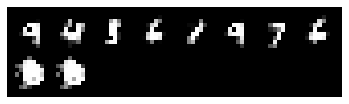

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 9/10] [Batch 599/600] [D loss: 0.647892] [G loss: 3.245421]


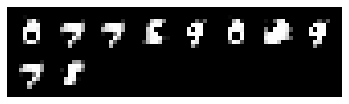

In [15]:
for epoch in range(epochs):
    for idx,(image,label) in enumerate(trainloader):
        generator.train()
        batch_size=image.size(0)
        
        image=image.to(device)
        label=label.to(device)

        real_label = real_labels[idx % 10]
        fake_label = fake_labels[idx % 10]

        # label flipping
        if idx % 7 == 0:
          real_label,fake_label=fake_label,real_label 
        
        d_loss,D_x=train_discriminator(batch_size,generator,discriminator,image,label,real_label,fake_label)
        g_loss=train_generator(batch_size,generator,discriminator)
    print(
          "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch, epochs, idx, len(trainloader), d_loss, g_loss))
    #To Generate Image after Each Epoch
    noise = torch.randn(10, 100, device=device)
    labels = torch.randint(0, 10, (10,), dtype=torch.long, device=device, )
    fakes = generator(noise, labels).unsqueeze(1).detach()
    showimage(make_grid(fakes).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


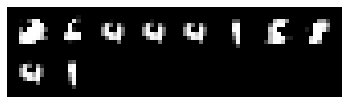

[Epoch 9/10] [Batch 599/600] [D loss: 0.647892] [G loss: 3.245421] [D(x): 0.781154]


In [16]:
noise = torch.randn(10, 100, device=device)
labels = torch.randint(0, 10, (10,), dtype=torch.long, device=device, )
fakes = generator(noise, labels).unsqueeze(1).detach()
showimage(make_grid(fakes).cpu())

print(
          "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [D(x): %f]"
          % (epoch, epochs, idx, len(trainloader), d_loss, g_loss,D_x))